<a href="https://colab.research.google.com/github/head1ton/EURI_ML/blob/main/image_background_remove/ImageBackgroundRemove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ecehf78y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ecehf78y
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=c241b578a04e5a869236ccdf7b587533eb0bf304b3d8751ea1ecfb9d7a96b750
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_xtwbj3/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [2]:
import torch
print(torch.__version__)

2.6.0+cu124


In [3]:
import os
from segment_anything import SamPredictor, sam_model_registry

In [4]:
model_path = "./sam_vit_b_01ec64.pth"

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O {model_path}

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)

--2025-03-27 10:09:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.33, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘./sam_vit_b_01ec64.pth’

./sam_vit_b_01ec64. 100%[===================>] 357.67M   182MB/s    in 2.0s    

2025-03-27 10:09:10 (182 MB/s) - ‘./sam_vit_b_01ec64.pth’ saved [375042383/375042383]



(538, 960, 3)


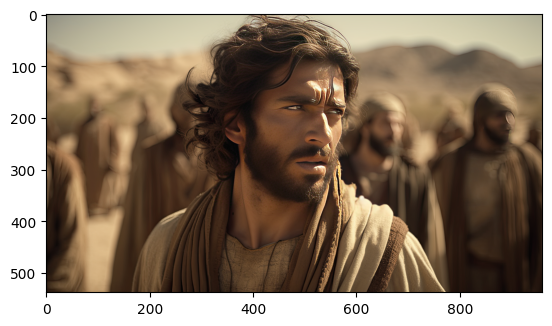

In [15]:
import cv2
import matplotlib.pyplot as plt

image_path = "person1.png"
image = cv2.imread(image_path)
print(image.shape)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
x = image.shape[1] // 2
y = image.shape[0] // 2
print(x, y)

480 269


In [7]:
import cv2

image_path = "person1.png"

x = 480
y = 269

image = cv2.imread(image_path)

In [8]:
import numpy as np


predictor.set_image(image)

masks, scores, logits = predictor.predict(
    point_coords=np.asarray([[x, y]]),
    point_labels=np.asarray([1]),   # 0은 배경 , 1은 객체
    multimask_output=True
)
# print('masks : ', masks)
# print('scores : ', scores)
# print('logits : ', logits)

In [11]:
masks.shape

(3, 538, 960)

In [9]:
C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype=bool)

for j in range(C):
    result_mask |= masks[j, :, :]

result_mask = result_mask.astype(np.uint8)

In [10]:
result_mask[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
result_mask.shape

(538, 960)

In [14]:
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_image = cv2.merge((image, alpha_channel))

In [16]:
import base64
import os
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np

def remove_background(image, x, y):

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=np.asarray([[x, y]]),
        point_labels=np.asarray([1]),   # 0은 배경 , 1은 객체
        multimask_output=True
    )

    C, H, W = masks.shape

    result_mask = np.zeros((H, W), dtype=bool)

    for j in range(C):
        result_mask |= masks[j, :, :]

    result_mask = result_mask.astype(np.uint8)

    alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

    alpha_channel[result_mask == 0] = 0

    result_image = cv2.merge((image, alpha_channel))

    return result_image

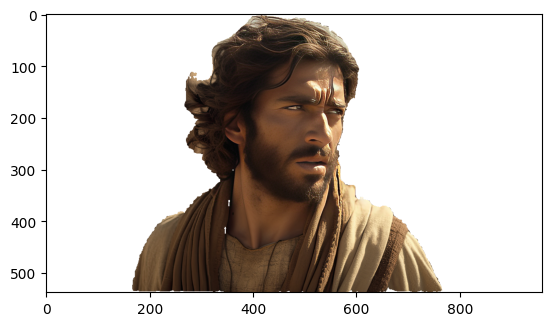

In [19]:
import cv2
image_path = "person1.png"

x = 480
y = 269

image = cv2.imread(image_path)

result_image = remove_background(image, x, y)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

In [20]:
import base64
import os
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np

def remove_background(image_base64_encoding, x, y):

    image_bytes = base64.b64decode(image_base64_encoding)

    image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=np.asarray([[x, y]]),
        point_labels=np.asarray([1]),   # 0은 배경 , 1은 객체
        multimask_output=True
    )

    C, H, W = masks.shape

    result_mask = np.zeros((H, W), dtype=bool)

    for j in range(C):
        result_mask |= masks[j, :, :]

    result_mask = result_mask.astype(np.uint8)

    alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

    alpha_channel[result_mask == 0] = 0

    result_image = cv2.merge((image, alpha_channel))

    _, result_image_bytes = cv2.imencode('.png', result_image)

    result_image_bytes = result_image_bytes.tobytes()

    result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

    return result_image_bytes_encoded_base64

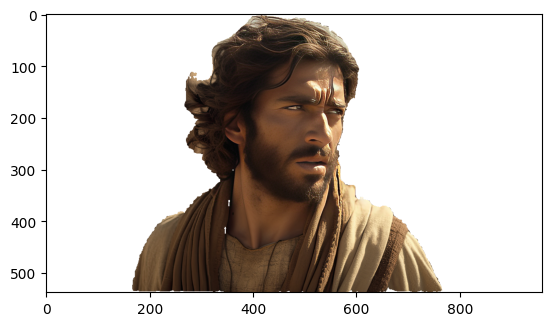

In [21]:
import cv2
import matplotlib.pyplot as plt

image_path = "person1.png"

x = 480
y = 269

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

result_image = remove_background(image_bytes_encoded_base64, x, y)

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

In [22]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [23]:
import modelbit

mb = modelbit.login()

In [24]:
mb.deploy(remove_background)

Encrypting 'predictor': 100%|██████████| 362M/362M [00:04<00:00, 90.0MB/s]
Uploading 'predictor': 100%|██████████| 335M/335M [00:07<00:00, 46.5MB/s]


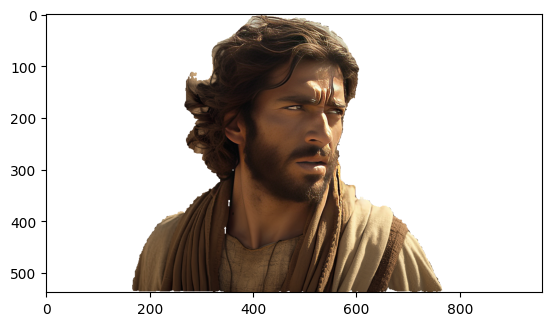

In [44]:
import cv2
import matplotlib.pyplot as plt
import requests
import modelbit

api_endpoint = "https://rick.us-east-2.aws.modelbit.com/v1/remove_background/latest"

image_path = "person1.png"

x = 480
y = 269

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# api_data = {'data': [image_bytes_encoded_base64, x, y]}
# response = requests.post(api_endpoint, json=api_data)
# result_image_bytes = base64.b64decode(response.json()['data'])

response = modelbit.get_inference(
  region="us-east-2.aws",
  workspace="rick",
  deployment="remove_background",
  version="latest",
  data=[image_bytes_encoded_base64, x, y]
)
result_image_bytes = base64.b64decode(response['data'])

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

In [2]:
!pip install streamlit
!pip install streamlit_image_coordinates

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [4]:
import base64
import os

import requests
import streamlit as st
from PIL import Image
from streamlit_image_coordinates import streamlit_image_coordinates as im_coordinates
import cv2
import numpy as np


st.set_page_config(layout='wide')

def set_background(image_file):
    """
    This function sets the background of a Streamlit app to an image specified by the given image file.

    Parameters:
        image_file (str): The path to the image file to be used as the background.

    Returns:
        None
    """
    with open(image_file, "rb") as f:
        img_data = f.read()
    b64_encoded = base64.b64encode(img_data).decode()
    style = f"""
        <style>
        .stApp {{
            background-image: url(data:image/png;base64,{b64_encoded});
            background-size: cover;
        }}
        </style>
    """
    st.markdown(style, unsafe_allow_html=True)


set_background('./background.jpg')

api_endpoint = "https://rick.us-east-2.aws.modelbit.com/v1/remove_background/latest"


col01, col02 = st.columns(2)

# file uploader
file = col02.file_uploader('', type=['jpeg', 'jpg', 'png'])

# read image
if file is not None:
    image = Image.open(file).convert('RGB')

    image = image.resize((880, int(image.height * 880 / image.width)))

    # create buttons
    col1, col2 = col02.columns(2)

    # visualize image
    # click on image, get coordinates
    placeholder0 = col02.empty()
    with placeholder0:
        value = im_coordinates(image)
        if value is not None:
            print(value)

    if col1.button('Original', use_container_width=True):
        placeholder0.empty()
        placeholder1 = col02.empty()
        with placeholder1:
            col02.image(image, use_column_width=True)

    if col2.button('Remove background', type='primary', use_container_width=True):
        # call api
        placeholder0.empty()
        placeholder2 = col02.empty()

        filename = '{}_{}_{}.png'.format(file.name, value['x'], value['y'])

        if os.path.exists(filename):
            result_image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        else:
            _, image_bytes = cv2.imencode('.png', np.asarray(image))

            image_bytes = image_bytes.tobytes()

            image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

            api_data = {"data": [image_bytes_encoded_base64, value['x'], value['y']]}
            response = requests.post(api_endpoint, json=api_data)

            result_image = response.json()['data']

            result_image_bytes = base64.b64decode(result_image)

            result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

            cv2.imwrite(filename, result_image)

        with placeholder2:
            col02.image(result_image, use_column_width=True)

2025-03-27 13:45:17.359 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 13:45:17.384 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 13:45:17.433 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-27 13:45:17.433 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 13:45:17.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 13:45:17.436 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 13:45:17.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [5]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.122.102:8501

  Stopping...
  Stopping...
Exception ignored in atexit callback: <function shutdown at 0x7a243606d3a0>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 2185, in shutdown
    h.flush()
  File "/usr/lib/python3.11/logging/__init__.py", line 1093, in flush
    if self.stream and hasattr(self.stream, "flush"):
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 44, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/server/server.py", line 470, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.11/dist-packages/streamlit/runtime/runtime.py", line 337, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File "/usr